In [1]:
import sys
sys.path.insert(1,'../')

import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from functools import partial

import qtrajectories as qtr

In [2]:
import usual_operators_ as op

In [3]:
# mMatrix_dag = np.transpose(np.conjugate(qtr_test.M_rep))
# sqrt_eta = op.sqrt_jit(np.eye(2*np.shape(L)[0]) - np.dot(mMatrix_dag, qtr_test.M_rep))

In [4]:
# 2*sqrt_eta

In [5]:
## Parameters 
gamma = 1
omega = 10

## Time parameters
t0 = 0.
tf = 10
time_steps = 100000
dt = int(abs(tf-t0)/time_steps)

## Time range
t = np.linspace(t0, tf, np.int32(time_steps))

## Initial state 
psi0 = np.array([1,1], dtype = np.complex128)
psi0 = (1/np.linalg.norm(psi0))*psi0
rho0 = np.asarray(np.transpose(np.asmatrix(psi0)).dot(np.conjugate(np.asmatrix(psi0)))) 

In [6]:
## Hamiltonian
H0 = omega/2.0 * qtr.sigmax

## lindblad operators
L = np.array([np.sqrt(gamma)*qtr.sigmam], dtype=np.complex128)

## feedback operators
F = np.array([qtr.sigmay, qtr.sigmaz], dtype=np.complex128)

## little u matrix
u_matrix = np.eye(1, dtype=np.complex128)

## Ortogonal freedom
# theta = 0
# oMatrix = np.array([[np.cos(theta), -np.sin(theta)],
#                   [np.sin(theta), np.cos(theta)]])

In [7]:
@jit(nopython=True)
def H0_func(x):
    return omega/2.0 * qtr.sigmax

@jit(nopython=True)
def L_func(t):
    num_op = 1
    L_list = np.zeros((num_op,2,2), dtype=np.complex128)
    L_list[0] = np.sqrt(gamma)*qtr.sigmam
    return L_list

@jit(nopython=True)
def F_func(t):
    num_op = 2
    F_list = np.zeros((num_op,2,2), dtype=np.complex128)
    F_list[0] = qtr.sigmay
    F_list[1] = qtr.sigmaz
    return F_list

## Adapative unraveling
@jit(nopython=True)
def uMatrix(t, rho):
    return np.array([[-np.trace(np.dot(rho,qtr.sigmam))/np.trace(np.dot(rho,qtr.sigmap))]])

In [8]:
# from importlib import reload 
# reload(qtr)

In [9]:
%%time
## System definition
qtr_test = qtr.System(H0, rho0, t, lindbladList = L, uMatrix=u_matrix)

CPU times: user 6.42 ms, sys: 977 µs, total: 7.4 ms
Wall time: 9.51 ms


In [18]:
%%time
qtr_test.update_representation(uMatrix=-1*u_matrix)

CPU times: user 885 µs, sys: 0 ns, total: 885 µs
Wall time: 887 µs


In [19]:
qtr_test.U_rep

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [20]:
%%time
coherent_fields = np.array([0,5], dtype=np.complex128)
test_traj = qtr_test.jumpRhoTrajectory(coherent_fields=coherent_fields, seed=5)

CPU times: user 1.14 s, sys: 4.25 ms, total: 1.15 s
Wall time: 1.15 s


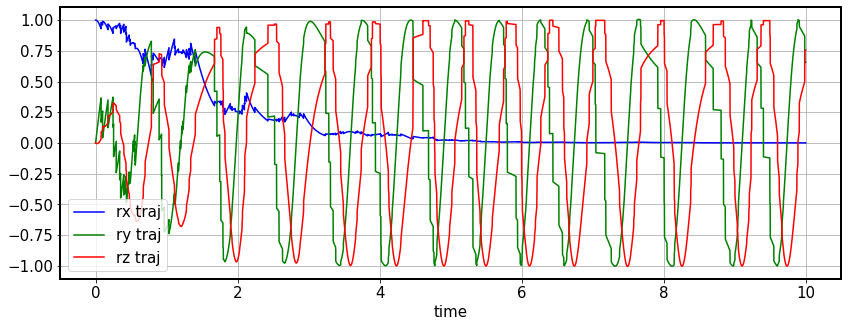

In [21]:
qtr.misc.rhoBlochrep(test_traj, qtr_test.timeList, label='traj')

In [14]:
%%time
test_traj_diff = qtr_test.diffusiveRhoTrajectory()

CPU times: user 801 ms, sys: 8.72 ms, total: 809 ms
Wall time: 818 ms


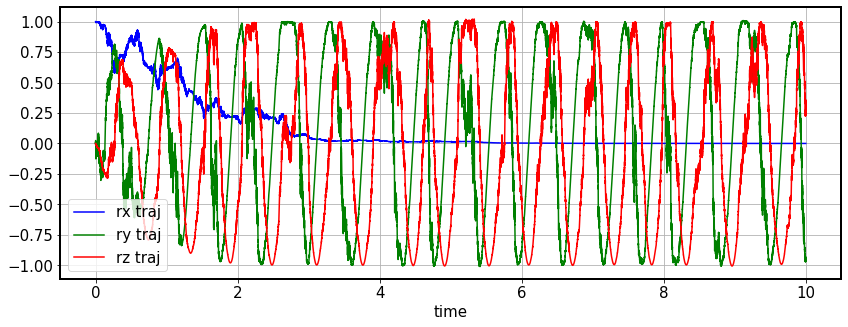

In [15]:
qtr.misc.rhoBlochrep(test_traj_diff, qtr_test.timeList, label='traj')

In [ ]:
%%time
n_trajectories = 1000
rho_lindblad = qtr_test.jumpRhoAverage(n_trajectories, coherent_fields=coherent_fields)

In [ ]:
qtr.misc.rhoBlochrep(rho_lindblad, qtr_test.timeList, label='traj')

In [ ]:
import integrators as itg
from scipy.integrate import solve_ivp

In [ ]:
op_lind = partial(itg.standartLindblad_operator, qtr_test.H, qtr_test.cList)
rho_T = itg.scipy_integrator(op_lind, rho0, t)

In [ ]:
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochrep(rho_T, t, label='analitical', ax=ax, line='--')
qtr.misc.rhoBlochrep(rho_lindblad, t, label='average', ax=ax)